In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
import os

def preprocess_data(df, label_col, feature_cols, coord_cols):
    # 识别分类变量
    categorical_columns = df[feature_cols].select_dtypes(include=['category']).columns
    
    # 使用LabelEncoder将分类变量转换为数值
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # 分离特征和标签
    X = df[feature_cols + coord_cols]
    y = df[label_col]
    
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler, label_encoders

def create_nn_spatial_attention_model(input_shape, num_features):
    inputs = layers.Input(shape=(input_shape,))
    
    # 提取坐标信息
    coords = layers.Lambda(lambda x: x[:, -2:])(inputs)
    
    # 特征处理
    features = layers.Dense(64, activation='relu')(inputs)
    features = layers.Dense(32, activation='relu')(features)
    
    # 空间注意力机制
    attention = layers.Dense(1, activation='tanh')(coords)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(32)(attention)
    attention = layers.Permute([2, 1])(attention)
    
    # 应用注意力
    merged = layers.Multiply()([features, attention])
    
    # 最终预测
    output = layers.Dense(16, activation='relu')(merged)
    output = layers.Dense(1)(output)
    
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

def train_and_evaluate_model(X, y, coord_cols, save_model_path):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建和训练模型
    model = create_nn_spatial_attention_model(X_train.shape[1], len(coord_cols))
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    
    # 预测
    y_train_pred = model.predict(X_train).flatten()  # 确保输出是1维的
    y_test_pred = model.predict(X_test).flatten()  # 确保输出是1维的
    
    # 评估
    r2_nn = r2_score(y_test, y_test_pred)
    mae_nn = mean_absolute_error(y_test, y_test_pred)
    mse_nn = mean_squared_error(y_test, y_test_pred)
    rmse_nn = np.sqrt(mse_nn)
    
    # 输出评估分数
    print(f"Neural Network R2: {r2_nn}")
    print(f"Neural Network MAE: {mae_nn}")
    print(f"Neural Network MSE: {mse_nn}")
    print(f"Neural Network RMSE: {rmse_nn}")
    
    # 绘制训练历史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'training_history.png'))
    
    # 保存模型
    model.save(save_model_path)
    
    return {
        "NeuralNetwork": {
            "R2": r2_nn,
            "MAE": mae_nn,
            "MSE": mse_nn,
            "RMSE": rmse_nn
        }
    }


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

def preprocess_data(df, label_col, feature_cols, coord_cols):
    # 识别分类变量
    categorical_columns = df[feature_cols].select_dtypes(include=['category']).columns
    
    # 使用LabelEncoder将分类变量转换为数值
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # 分离特征和标签
    X = df[feature_cols + coord_cols]
    y = df[label_col]
    
    # 标准化特征
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    # 标准化目标变量
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    return X_scaled, y_scaled, scaler_X, scaler_y, label_encoders

def create_improved_nn_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    
    # 提取坐标信息
    coords = layers.Lambda(lambda x: x[:, -2:])(inputs)
    
    # 特征处理
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # 空间注意力机制
    attention = layers.Dense(32, activation='tanh')(coords)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    attention = layers.Flatten()(attention)
    
    # 应用注意力
    x = layers.Multiply()([x, attention])
    
    # 最终预测
    output = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(1)(output)
    
    model = models.Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

def train_and_evaluate_model(X, y, coord_cols, save_model_path):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建模型
    model = create_improved_nn_model(X_train.shape[1])
    
    # 定义回调函数
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    # 训练模型
    history = model.fit(
        X_train, y_train,
        epochs=1000,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # 预测
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()
    
    # 评估
    r2_nn = r2_score(y_test, y_test_pred)
    mae_nn = mean_absolute_error(y_test, y_test_pred)
    mse_nn = mean_squared_error(y_test, y_test_pred)
    rmse_nn = np.sqrt(mse_nn)
    
    # 输出评估分数
    print(f"Neural Network R2: {r2_nn}")
    print(f"Neural Network MAE: {mae_nn}")
    print(f"Neural Network MSE: {mse_nn}")
    print(f"Neural Network RMSE: {rmse_nn}")
    
    # 绘制训练历史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'training_history.png'))
    
    # 保存模型
    model.save(save_model_path)
    
    return {
        "NeuralNetwork": {
            "R2": r2_nn,
            "MAE": mae_nn,
            "MSE": mse_nn,
            "RMSE": rmse_nn
        }
    }


1159
Epoch 1/1000
24/24 [==============================] - 1s 4ms/step - loss: 2.7210 - val_loss: 2.4139 - lr: 0.0010
Epoch 2/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.4349 - val_loss: 2.3476 - lr: 0.0010
Epoch 3/1000
24/24 [==============================] - 0s 1ms/step - loss: 2.3074 - val_loss: 2.2852 - lr: 0.0010
Epoch 4/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.2425 - val_loss: 2.2270 - lr: 0.0010
Epoch 5/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.1897 - val_loss: 2.1727 - lr: 0.0010
Epoch 6/1000
24/24 [==============================] - 0s 1ms/step - loss: 2.1120 - val_loss: 2.1126 - lr: 0.0010
Epoch 7/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.0741 - val_loss: 2.0759 - lr: 0.0010
Epoch 8/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.0106 - val_loss: 2.0213 - lr: 0.0010
Epoch 9/1000
24/24 [==============================] - 0s 1ms/step - loss: 1.9601 - val_loss

d:\worker_code\.venvgis\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


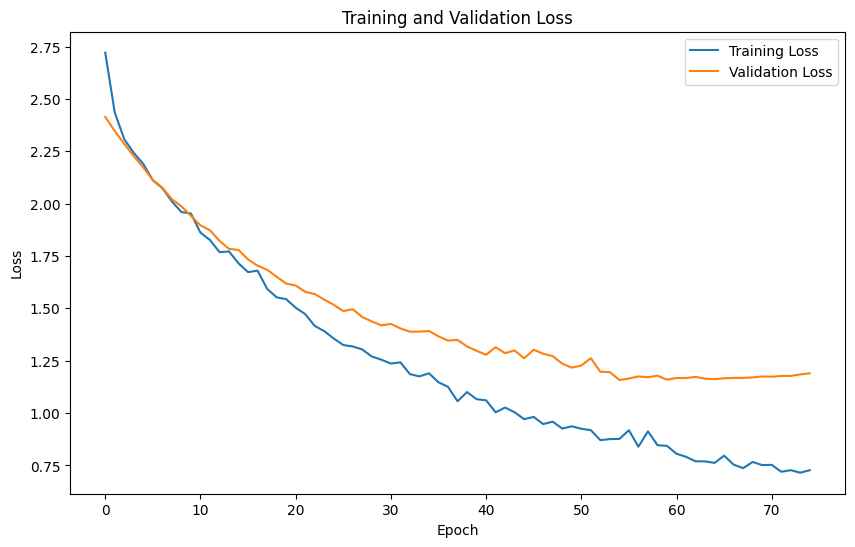

In [5]:
# 使用示例
if __name__ == "__main__":
    # 假设您已经准备好了数据
    # 读取数据
    df = pd.read_csv(r"F:\cache_data\pre_property_table\dy\feature_ph_dy.csv")
    print(len(df))
    # 删除有缺失值的行
    # data.dropna(inplace=True)
    # len(data),data.columns

    # 选择数值列并计算它们的均值
    numeric_cols = df.select_dtypes(include=[np.number])
    means = numeric_cols.mean()
    # 使用均值填充每个数值列的缺失值
    df[numeric_cols.columns] = df[numeric_cols.columns].fillna(means)
    
    # 确保分类变量被正确识别
    df['DL'] = df['DL'].astype('category')
    df['DZ'] = df['DZ'].astype('category')
    df['SlopeClass'] = df['SlopeClass'].astype('category')
    
    label_col = "ph"
    coord_cols = ["LON", "LAT"]
    # 用户选择的标签列和特征列
    # label_col = "ph"
    feature_cols = ['DEM', 'AnalyticalHillshading', 'Aspect',
        'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
        'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF',
        'PlanCurvature', 'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
        'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
        'NIGHT2022', 'ETP2022_mean', 'TMP2022_mean', 'PRE2022_mean',
        'PRE2022_3', 'PRE2022_11', 'ETP2022_3', 'ETP2022_11', 'TMP2022_3',
        'TMP2022_11', 'evi', 'lswi', 'mndwi', 'ndmi', 'ndvi', 'ndwi', 'PCA_0',
        'PCA_1', 'savi', 'vari', 'DL', 'DZ','SlopeClass']
        
    # 预处理数据
    X_scaled, y_scaled, scaler_X, scaler_y, label_encoders = preprocess_data(df, label_col, feature_cols, coord_cols)
    
    save_model_path = r"F:\cache_data\model_path\dy\NN\nn_spatial_attention_model.h5"
    
    # 训练和评估模型
    results = train_and_evaluate_model(X_scaled, y_scaled, coord_cols, save_model_path)
    print(results)